In [78]:
import sys
sys.path.append("../")
import numpy as np
import matplotlib.pyplot as plt
import torch

from vision_base.utils.builder import build
from vision_base.data.datasets.dataset_utils import collate_fn
from vision_base.utils.utils import cfg_from_file

print('CUDA available: {}'.format(torch.cuda.is_available()))

#cfg = cfg_from_file("../configs/kitti360_gtpose_config.py")
#cfg = cfg_from_file("../configs/distill_monodepth2_gt_poseconfig.py")
#cfg = cfg_from_file("../configs/nusc_monodepth2wpose_config.py")
#cfg = cfg_from_file("../configs/monodepth2_gtpose_uncertainty_config.py")
cfg = cfg_from_file("/home/yliuhb/vision_collection/model/monodepth/res101_monodepth_large_cfg.py")
is_test_train = True

#checkpoint_name = "../workdirs/MonoDepth2_pose/checkpoint/MonoDepthWPose_ss11.pth"
#checkpoint_name = "../workdirs/Distillation_gtpose/checkpoint/DistillWPoseMeta_trained_ss8.pth"
#checkpoint_name = "../workdirs/MonoDepth2Nusc/checkpoint/MonoDepthWPose_ss11_threecam.pth"
checkpoint_name = "/home/yliuhb/vision_collection/model/monodepth/res101_monodepth_large.pth"

CUDA available: True


In [79]:
index = 0
split_to_test='validation'
cfg.train_dataset.augmentation = cfg.val_dataset.augmentation
is_test_train = split_to_test == 'training'
if split_to_test == 'training':
    dataset = build(**cfg.train_dataset)
elif split_to_test == 'test':
    dataset = build(**cfg.test_dataset)
else:
    dataset = build(**cfg.val_dataset)


meta_arch = build(**cfg.meta_arch)
meta_arch = meta_arch.cuda()

weight_path = checkpoint_name
state_dict = torch.load(weight_path, map_location='cuda:{}'.format(cfg.trainer.gpu))

meta_arch.load_state_dict(state_dict['model_state_dict'])
meta_arch.eval();

test_hook = build(**cfg.trainer.evaluate_hook.test_run_hook_cfg)

In [80]:
def denorm(image):
    new_image = np.clip((image * cfg.data.augmentation.rgb_std +  cfg.data.augmentation.rgb_mean) * 255, 0, 255)
    new_image = np.array(new_image, dtype=np.uint8)
    return new_image

from numba import jit
@jit(cache=False, nopython=True)
def ToColorDepth(depth_image:np.ndarray)->np.ndarray: #[H, W] -> [H, W, 3]
    H, W = depth_image.shape
    max_depth = float(np.max(depth_image))
    cmap = np.array([
        [0,0,0,114],[0,0,1,185],[1,0,0,114],[1,0,1,174], 
        [0,1,0,114],[0,1,1,185],[1,1,0,114],[1,1,1,0]
    ])
    _sum  = 0
    for i in range(8):
        _sum += cmap[i, 3]
    
    weights = np.zeros(8)
    cumsum = np.zeros(8)
    for i in range(7):
        weights[i] = _sum / cmap[i, 3]
        cumsum[i+1] = cumsum[i] + cmap[i, 3] / _sum
    
    image = np.zeros((H, W, 3), dtype=np.uint8)
    for i in range(H):
        for j in range(W):
            val = depth_image[i, j] / max_depth
            for k in range(7):
                if val <= cumsum[k + 1]:
                    break
            w = 1.0- (val - cumsum[k]) * weights[k]
            r = int( (w * cmap[k, 0] + (1 - w) * cmap[k+1, 0]) * 255 )
            g = int( (w * cmap[k, 1] + (1 - w) * cmap[k+1, 1]) * 255 )
            b = int( (w * cmap[k, 2] + (1 - w) * cmap[k+1, 2]) * 255 )
            image[i, j] = np.array([r,g,b])
    return image


In [81]:
def compute_once(index):
    data = dataset[index]
    h_eff, w_eff = data[('image_resize', 'effective_size')]
    collated_data = collate_fn([data])
    image = collated_data[('image', 0)]
    rgb_image = denorm(image[0].cpu().numpy().transpose([1, 2, 0]))
    with torch.no_grad():
        output_dict = test_hook(collated_data, meta_arch)
        depth = output_dict["depth"][0, 0]
        print(depth.max(), depth.min())
        depth_uint16 = (depth * 256).cpu().numpy().astype(np.uint16)
        color_depth = ToColorDepth(depth_uint16)
       
    plt.subplot(2, 2, 1)
    
    plt.imshow(np.clip(rgb_image, 0, 255)[0:h_eff, 0:w_eff])
    plt.subplot(2, 2, 2)
    plt.imshow( 1 / (depth_uint16 / 256)[0:h_eff, 0:w_eff], cmap='magma', vmin=1.0/(70), vmax= 1 / max(depth_uint16.min()/256, 2.0) )
    
    
    plt.subplot(2, 2, 3)
    color_depth = ToColorDepth(depth_uint16)
    plt.imshow(depth_uint16 / 256)
    
    plt.subplot(2, 2, 4)
    alpha = 0.3
    masked = (alpha * color_depth + (1 - alpha) * rgb_image).astype(np.uint8)
    plt.imshow(masked)

    plt.show()
    return np.clip(rgb_image, 0, 255), color_depth, depth_uint16

986
tensor(62.6518, device='cuda:0') tensor(2.7542, device='cuda:0')


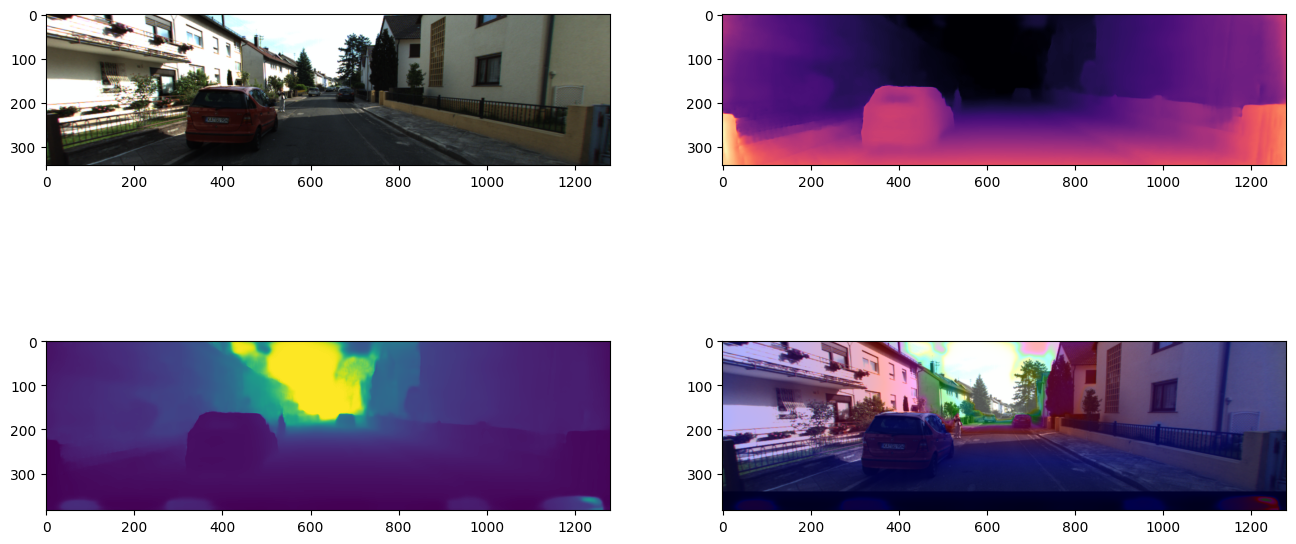

In [91]:
%matplotlib inline
index = np.random.randint(0, len(dataset))
print(len(dataset))
fig = plt.figure(figsize=(16, 8))

rgb_image, color_depth, depth_uint16  = compute_once(index);